#### Second challange analysis; amount of imperatives in portal news headlines

This time it's more about getting categorised data, analysis is a bit basic and contain model to be developed. Process:
- scrapping article headlines out of news portal
- also: out of many categories and sub-categories inside the portal
- simple cleaning of categories
- also: getting categories out of url
- simple imperatives model (100% exploratory, ~60 words to see if preasumptions sticks)
- simple exploration of category and imperative counts
- averages, proportions
- (a bit less ugly than before) results visualisation

Simple warm up analysis.
Just getting started, keep watching the progress.

In [1]:
from bs4 import BeautifulSoup
import urllib3
import certifi
import csv
from datetime import datetime
from itertools import repeat

import pandas as pd

In [ ]:
def get_soup_out_of_url(url):
    http = urllib3.PoolManager(cert_reqs='CERT_REQUIRED', ca_certs=certifi.where())
    response = http.request('GET', url)
    soup = BeautifulSoup(response.data)
    return soup

def get_page(url, menu):
    html_soup = get_soup_out_of_url(url)
    html_body = html_soup.find('body')
    if menu:
        html_menu = html_body.find('ul', menu)
    return html_menu

def get_categories(html_menu):
    categories = []
    for menu_item in html_menu:
        menu_item = str(menu_item.find('a'))
        if len(menu_item) < 50:
            continue
        menu_item = menu_item.split('href="')[1]
        menu_item = menu_item.split('">')[0]
        category = menu_item.strip()
        if category.startswith('http'):
            category = "/" + category.split('//')[1].split('.')[0]
        #print('>', category)
        categories.append(category)
    categories = set(categories)
    #print(len(categories))
    return categories
        
def get_all_categories(main_categories):
    all_categories = {}
    for cat in main_categories:
        all_categories[cat + "_" + str('00')] = cat
    
        url = ''.join([url_main, cat])
        html_menu = get_page(url, 'subMenu collapsible')
    
        if not html_menu:
            continue
        
        categories = get_categories(html_menu)
    
        for i, category in enumerate(categories):
            all_categories[cat + "_" + str(i)] = category

            sub_url = url_main + sub_categories[cat + "_" + str(i)]
            html_menu = get_page(sub_url, 'subMenu collapsible')
        
            if not html_menu:
                continue
            
            cats_from_cats = get_categories(html_menu)
        
            for ii, cat_from_cats in enumerate(cats_from_cats):
                all_categories[category + "_" + str(ii)] = cat_from_cats

    for i, (k,v) in enumerate(sub_categories.items()):
        all_categories[k] = url_main + v
    return all_categories

def create_category_dataframe(data):
    df = pd.DataFrame(sub_categories, index=['raw']).T
    df['raw'] = df.raw.str.partition(''.join([url_main,url_main])[2])
    df['categories'] = df.raw.str.partition('onet.pl/')[2]
    df['category_1'] = df.categories.str.partition('/')[0]
    df['category_2'] = df.categories.str.partition('/')[2]
    df['category_3'] = df.category_2.str.partition('/')[2]
    df['category_2'] = df.category_2.str.partition('/')[0]
    del df['categories']
    df.drop_duplicates('raw', keep='first', inplace=True)
    df.index = range(len(df))
    df.to_csv('onet_categories.csv')
    return df

def get_soup_out_of_url(url):
    http = urllib3.PoolManager(cert_reqs='CERT_REQUIRED', ca_certs=certifi.where())
    response = http.request('GET', url)
    soup = BeautifulSoup(response.data)
    return soup

def get_headlines_from_pages(cat_urls):
    all_headlines = []
    for nr, category_url in enumerate(cat_urls):
        url = category_url
        try:
            html_soup = get_soup_out_of_url(url)
            html_body = html_soup.find('body')
            article_titles = html_body.find_all('h3')
            headlines = []
            for a in article_titles:
                a = str(a)
                a = a.split(">")
                a = a[1]
                a = a.split('</h3')
                a = a[0]
                headlines.append(a)

            headlines = set(headlines)
            category = repeat(category_url, len(headlines))
        
            df = pd.DataFrame([headlines, category], index=['headlines', 'category']).T
            all_headlines.append(df)
            print('nr {} done. Links: {} from {}'.format(nr, len(article_titles), category_url))
        # Load as dataframe
        except:
            print(nr)
            print('crash')
            bdf = pd.concat(all_headlines)
            bdf.to_csv('bdf.csv')
            print(saved)
            continue
    
    bdf = pd.concat(all_headlines)
    bdf.drop_duplicates('headlines', inplace=True)
    bdf.index = range(len(bdf))
    path = url_main.split('//')[1].split('.onet')[0] + '.csv'
    if path:
        bdf.to_csv(path)
    else:
        bdf.to_csv(url_main.split('//')[1] + ".csv")
    return bdf

def get_portal_headlines_from_all_categories(portal_url):
    # Main portal page we will scrap.
    url_main = portal_url

    # Get main categories
    main_categories = get_categories(get_page(url_main, 'mainMenu'))

    # Get all categories
    all_categories = get_all_categories(main_categories)

    #     for i, (k,v) in enumerate(all_categories.items()):
    #         all_categories[k] = url_main + v
    #         print(i, all_categories[k], '\nCategory:', k[1:-2])
    #     print(i)

    df = create_category_dataframe(sub_categories)
    display(df.category_1.value_counts())

    cat_urls = df.raw.tolist()
    bdf = get_headlines_from_pages(cat_urls)
    print(len(bdf))
    display(bdf.head(5))
    return bdf
    
#portal_url = 'https://kobieta.onet.pl'
portal_urls = ['https://kultura.onet.pl/',
              'https://moto.onet.pl/',
              'https://businessinsider.com.pl/',
              'https://podroze.onet.pl/',
              'https://technologie.onet.pl/']

bdfs = []
for portal_url in portal_urls:
    print('\nStarting to scrap {}\n'.format(portal_url))
    bdf = get_portal_headlines_from_all_categories(portal_url)
    bdfs.append(bdf)

final_df = pd.concat(bdfs)
final_df.drop_duplicates('headlines', inplace=True)
final_df.index = range(len(final_df))
final_df.to_csv('all_headlines.csv')
print(final_df.shape)
final_df.head(5)

In [140]:
# Example output from kobieta.onet (I just was banned for scrapping for some time :> )
for i, (k,v) in enumerate(all_categories.items()):
    all_categories[k] = url_main + v
    print(i, all_categories[k], '\nCategory:', k[1:-2])
    print(i)

nr 0 done. Links: 30 from https://kobieta.onet.pl/dziecko/niemowle
nr 1 done. Links: 30 from https://kobieta.onet.pl/dziecko/niemowle/noworodek
nr 2 done. Links: 30 from https://kobieta.onet.pl/dziecko/niemowle/choroby-niemowlece
nr 3 done. Links: 30 from https://kobieta.onet.pl/kobieta
nr 4 done. Links: 30 from https://kobieta.onet.pl/dziecko/ciekawostki
nr 5 done. Links: 30 from https://kobieta.onet.pl/dziecko/ciaza-i-porod
nr 6 done. Links: 18 from https://kobieta.onet.pl/kalendarz-ciazy
nr 7 done. Links: 30 from https://kobieta.onet.pl/dziecko/ciaza-i-porod/polog
nr 8 done. Links: 30 from https://kobieta.onet.pl/dziecko/ciaza-i-porod/porod
nr 9 done. Links: 30 from https://kobieta.onet.pl/dziecko/ciaza-i-porod/ciaza
nr 10 done. Links: 30 from https://kobieta.onet.pl/dziecko/przed-ciaza
nr 11 done. Links: 11 from https://kobieta.onet.pl/dziecko/przed-ciaza/antykoncepcja
nr 12 done. Links: 30 from https://kobieta.onet.pl/dziecko/przed-ciaza/nieplodnosc
nr 13 done. Links: 30 from http

In [165]:
# Yeah, i just got banned.

# So we will work on one portal data only and wait for connection for more and it will be sweet.

# lets load data from CSV first:
headlines_data = pd.read_csv('bdf.csv')

# But 2204 article headlines doesn't suck either.
print('Unique headlines: {}'.format(headlines_data.headlines.unique().shape[0]))

# Categories looks bad
headlines_data.head(5)

Unique headlines: 2205


,Unnamed: 0,headlines,category
0,0,"Parentingowe rewolucje, czyli rozwiązania, któ...",https://kobieta.onet.pl/dziecko/niemowle
1,1,Imiona dla dziewczynek i chłopców inspirowane ...,https://kobieta.onet.pl/dziecko/niemowle
2,2,Na basen z bobasem - najlepsza aktywność od pi...,https://kobieta.onet.pl/dziecko/niemowle
3,3,"10 popularnych imion, których zdrobnienia nie ...",https://kobieta.onet.pl/dziecko/niemowle
4,4,Już co czwarte dziecko w Polsce jest pozamałże...,https://kobieta.onet.pl/dziecko/niemowle


In [377]:
hd = headlines_data.copy(deep=True)
del hd[hd.columns[0]]
hd['link'] = hd.category
hd['categories'] = hd.category.str.partition('onet.pl/')[2]
hd['category_1'] = hd.categories.str.partition('/')[0]
hd['category_2'] = hd.categories.str.partition('/')[2]
hd['category_2'] = hd.category_2.str.partition('/')[0]
del hd['category']
hd.head(10)

,headlines,link,categories,category_1,category_2
0,"Parentingowe rewolucje, czyli rozwiązania, któ...",https://kobieta.onet.pl/dziecko/niemowle,dziecko/niemowle,dziecko,niemowle
1,Imiona dla dziewczynek i chłopców inspirowane ...,https://kobieta.onet.pl/dziecko/niemowle,dziecko/niemowle,dziecko,niemowle
2,Na basen z bobasem - najlepsza aktywność od pi...,https://kobieta.onet.pl/dziecko/niemowle,dziecko/niemowle,dziecko,niemowle
3,"10 popularnych imion, których zdrobnienia nie ...",https://kobieta.onet.pl/dziecko/niemowle,dziecko/niemowle,dziecko,niemowle
4,Już co czwarte dziecko w Polsce jest pozamałże...,https://kobieta.onet.pl/dziecko/niemowle,dziecko/niemowle,dziecko,niemowle
5,"Kaszka czy płatki zjedzone na noc nie sprawią,...",https://kobieta.onet.pl/dziecko/niemowle,dziecko/niemowle,dziecko,niemowle
6,Pocałunek może nawet zabić. Niemowlę umarło z ...,https://kobieta.onet.pl/dziecko/niemowle,dziecko/niemowle,dziecko,niemowle
7,Premier Nowej Zelandii trzy tygodnie temu urod...,https://kobieta.onet.pl/dziecko/niemowle,dziecko/niemowle,dziecko,niemowle
8,"Wpis znanej fit mamy zaskoczył wszystkich. ""Pr...",https://kobieta.onet.pl/dziecko/niemowle,dziecko/niemowle,dziecko,niemowle
9,Wychowanie bezpieluszkowe – radykalny ekotrend...,https://kobieta.onet.pl/dziecko/niemowle,dziecko/niemowle,dziecko,niemowle


In [378]:
hd.head(5)

,headlines,link,categories,category_1,category_2
0,"Parentingowe rewolucje, czyli rozwiązania, któ...",https://kobieta.onet.pl/dziecko/niemowle,dziecko/niemowle,dziecko,niemowle
1,Imiona dla dziewczynek i chłopców inspirowane ...,https://kobieta.onet.pl/dziecko/niemowle,dziecko/niemowle,dziecko,niemowle
2,Na basen z bobasem - najlepsza aktywność od pi...,https://kobieta.onet.pl/dziecko/niemowle,dziecko/niemowle,dziecko,niemowle
3,"10 popularnych imion, których zdrobnienia nie ...",https://kobieta.onet.pl/dziecko/niemowle,dziecko/niemowle,dziecko,niemowle
4,Już co czwarte dziecko w Polsce jest pozamałże...,https://kobieta.onet.pl/dziecko/niemowle,dziecko/niemowle,dziecko,niemowle


In [379]:
# Our main categories
hd.category_1.value_counts()

zdrowie            654
dziecko            613
dom                297
uroda              230
moda               189
slub               147
kobieta             30
diety               28
magia               13
kobiecesprawy        1
kalendarz-ciazy      1
Name: category_1, dtype: int64

In [380]:
# Our sub-categories
hd.category_2.value_counts()

porady-ekspertow           157
profilaktyka               147
psychologia                125
zycie-i-zdrowie            106
starsze-dziecko             93
ciaza-i-porod               90
seks                        89
niemowle                    83
male-dziecko                76
                            73
fryzury                     60
nowosci-rynkowe             60
przed-ciaza                 59
fitness                     59
nastolatki                  33
testy-kosmetykow            30
stylizacje-gwiazd           30
organizacja                 30
ciekawostki                 30
to-jest-hot                 30
wiadomosci                  30
ogrod                       30
przedpokoj                  30
obyczaje                    30
musisz-to-miec              30
najnowsze-trendy            30
buty                        30
manicure                    30
dieta-dziecka               30
aranzacje                   30
kosmetyki                   30
porady                      30
suknie  

In [382]:
hdd = hd.copy(deep=True)
hdd['headlines'] = hdd.headlines.str.lower()
hdd['points'] = 0
hdd['criteria'] = 0
display(hdd.head(5))

,headlines,link,categories,category_1,category_2,points,criteria
0,"parentingowe rewolucje, czyli rozwiązania, któ...",https://kobieta.onet.pl/dziecko/niemowle,dziecko/niemowle,dziecko,niemowle,0,0
1,imiona dla dziewczynek i chłopców inspirowane ...,https://kobieta.onet.pl/dziecko/niemowle,dziecko/niemowle,dziecko,niemowle,0,0
2,na basen z bobasem - najlepsza aktywność od pi...,https://kobieta.onet.pl/dziecko/niemowle,dziecko/niemowle,dziecko,niemowle,0,0
3,"10 popularnych imion, których zdrobnienia nie ...",https://kobieta.onet.pl/dziecko/niemowle,dziecko/niemowle,dziecko,niemowle,0,0
4,już co czwarte dziecko w polsce jest pozamałże...,https://kobieta.onet.pl/dziecko/niemowle,dziecko/niemowle,dziecko,niemowle,0,0


In [471]:
# Example words
words = ['jak', 
         'trik', 
         'uważaj','uwaga',
         'sposób','metoda',
         'zrób','zrobisz',
         'musisz', 'musi', 'trzeba',
         'nie wolno', 'zakaz', 
         'zostać', 'zostaniesz', 'bądź', 
         'niech',
         'weź', 'zostaw',
         'wyjdź', 'idź', 
         'pisz', 'ucz', 'mów', 'śpij', 'pracuj', 'rób',
         'tańcz', 'skocz', 'pomagaj',
         'powinien', 'powinnaś','rada', 'radzi', 'rady', 'poradź','radza',
         'chwalcie', 'chwal', 
         'poznaj', 'odkryj', 'zrozum', 'zobacz',
         'sprawdź', 'testuj', 'kup', 'zrób', 'dostań',
         'może szkodzić',
         'załóż', 'noś', 'użyj',
         'zarób','sprzedaj', 'oddaj',
         'wzmocjnij', 'zadbaj','oczyść','oczysc', 'regeneruj', 'odnów', 'odnowić']

word_counts = {}
for w in words:
    hdd[w] = hdd.headlines.str.contains(w).astype(int)
    count = hdd[hdd.headlines.str.contains(w) == True].shape[0]
    word_counts[w] = count
    print('{:15} {:3}'.format(w, count))
    

jak             338
trik             17
uważaj            5
uwaga             1
sposób           45
metoda            2
zrób              5
zrobisz           3
musisz            7
musi             19
trzeba            8
nie wolno         3
zakaz             2
zostać            1
zostaniesz        1
bądź              2
niech             4
weź               2
zostaw            6
wyjdź             1
idź               1
pisz              8
ucz              31
mów              31
śpij              1
pracuj            2
rób              18
tańcz             2
skocz             8
pomagaj           2
powinien          5
powinnaś          4
rada              5
radzi            14
rady             10
poradź            0
radza             4
chwalcie          1
chwal             2
poznaj           19
odkryj            1
zrozum            1
zobacz           55
sprawdź          72
testuj           20
kup              15
zrób              5
dostań            0
może szkodzić     1
załóż             0


In [472]:
for i in range(len(hdd)):
    hdd.loc[i,'points'] = hdd.loc[i,hdd.columns[7:]].sum()
    hdd.loc[i,'criteria'] = hdd.loc[i,hdd.columns[7:]].sum()
    if hdd.loc[i,'criteria'] > 0:
        hdd.loc[i,'criteria'] = 1
hdd.head(5)

,headlines,link,categories,category_1,category_2,points,criteria,jak,trik,uważaj,...,zarób,sprzedaj,oddaj,wzmocjnij,zadbaj,oczyść,oczysc,regeneruj,odnów,odnowić
0,"parentingowe rewolucje, czyli rozwiązania, któ...",https://kobieta.onet.pl/dziecko/niemowle,dziecko/niemowle,dziecko,niemowle,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,imiona dla dziewczynek i chłopców inspirowane ...,https://kobieta.onet.pl/dziecko/niemowle,dziecko/niemowle,dziecko,niemowle,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,na basen z bobasem - najlepsza aktywność od pi...,https://kobieta.onet.pl/dziecko/niemowle,dziecko/niemowle,dziecko,niemowle,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"10 popularnych imion, których zdrobnienia nie ...",https://kobieta.onet.pl/dziecko/niemowle,dziecko/niemowle,dziecko,niemowle,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,już co czwarte dziecko w polsce jest pozamałże...,https://kobieta.onet.pl/dziecko/niemowle,dziecko/niemowle,dziecko,niemowle,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [473]:
for criteria in range(0, 10):
    print('Minumum points is {}, there are: {} headlines.'.format(criteria, hdd[hdd.points >= criteria].shape[0]))

Minumum points is 0, there are: 2205 headlines.
Minumum points is 1, there are: 723 headlines.
Minumum points is 2, there are: 140 headlines.
Minumum points is 3, there are: 12 headlines.
Minumum points is 4, there are: 1 headlines.
Minumum points is 5, there are: 0 headlines.
Minumum points is 6, there are: 0 headlines.
Minumum points is 7, there are: 0 headlines.
Minumum points is 8, there are: 0 headlines.
Minumum points is 9, there are: 0 headlines.


In [474]:
categories_prop = {}
k_categories = hdd.category_1.unique().tolist()
for k in k_categories:
    cat_df = hdd[hdd.category_1 == k]
    points = int(cat_df.criteria.sum())
    max_p = cat_df.shape[0]
    if max_p >= 50:
        prop = points / max_p
        print('{:15}: {:3}/{:3} = {}'.format(k, points, max_p, prop))
        categories_prop[k] = prop

dziecko        : 210/613 = 0.3425774877650897
slub           :  37/147 = 0.25170068027210885
moda           :  38/189 = 0.20105820105820105
dom            : 139/297 = 0.468013468013468
zdrowie        : 215/654 = 0.3287461773700306
uroda          :  75/230 = 0.32608695652173914


In [475]:
column_name = 'advices_and_orders'

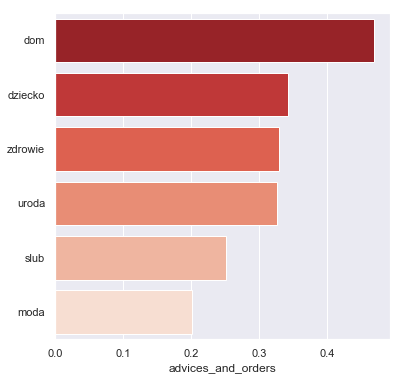

In [476]:
import matplotlib.pyplot as plt
import seaborn as sns 

cat_df = pd.DataFrame(categories_prop, index=[column_name]).T.sort_values(by=[column_name], ascending=False)
sns.set(rc={'figure.figsize':(6,6)})
sns.barplot(x=cat_df[column_name], y=cat_df.index, palette="Reds_r")

In [477]:
subcategories_prop = {}
k_categories = hdd.category_2.unique().tolist()
for k in k_categories:
    cat_df = hdd[hdd.category_2 == k]
    points = int(cat_df.criteria.sum())
    max_p = cat_df.shape[0]
    if max_p >= 20:
        prop = points / max_p
        print('{:50}: {:3}/{:3} = {}'.format(k, points, max_p, prop))
        subcategories_prop[k] = prop

niemowle                                          :  21/ 83 = 0.25301204819277107
                                                  :   9/ 73 = 0.1232876712328767
ciekawostki                                       :  26/ 30 = 0.8666666666666667
ciaza-i-porod                                     :  19/ 90 = 0.2111111111111111
przed-ciaza                                       :  28/ 59 = 0.4745762711864407
starsze-dziecko                                   :  45/ 93 = 0.4838709677419355
dieta-dziecka                                     :  10/ 30 = 0.3333333333333333
nastolatki                                        :  11/ 33 = 0.3333333333333333
male-dziecko                                      :  19/ 76 = 0.25
porady-ekspertow                                  :  39/157 = 0.2484076433121019
nowosci-rynkowe                                   :  17/ 60 = 0.2833333333333333
obyczaje                                          :   6/ 30 = 0.2
fryzury                                           :  12/

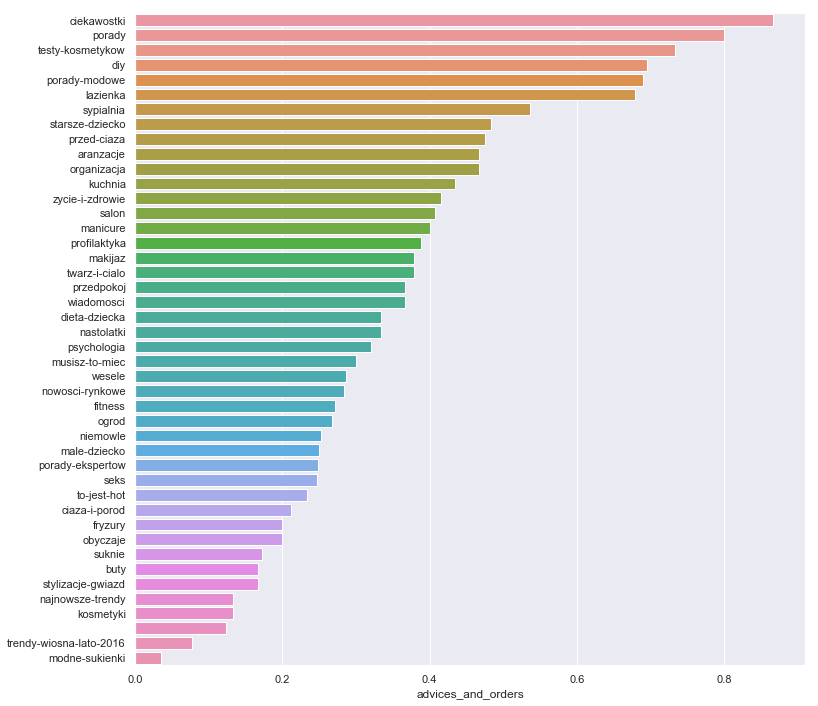

In [478]:
sub_df = pd.DataFrame(subcategories_prop, index=[column_name]).T.sort_values(by=[column_name], ascending=False)
sns.set(rc={'figure.figsize':(12,12)})
sns.barplot(x=sub_df[column_name], y=sub_df.index)

In [493]:
data = {'Words used to classify orders and advices' : len(words),
        'Orders_and_advices_sum': hdd.criteria.sum(),
        'All_headlines': hdd.shape[0]}
df_general = pd.DataFrame(data,index=['Data numbers:'])
df_general['proportion of orders and advices'] = ((df_general.Orders_and_advices_sum / df_general.All_headlines).round(2) * 100).astype(str) + '%'
df_general

,Words used to classify orders and advices,Orders_and_advices_sum,All_headlines,proportion of orders and advices
Data numbers:,62,723,2205,33.0%
